# 6. Plot All Results

gg-napari-env

In [16]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import regionprops
from scipy import stats
from napari_czifile2 import napari_get_reader
from skimage import io
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [17]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
# Get directories that contains 488, 546 or 647 
raw_data_dirs = [x for x in raw_data_dirs if 'P14' in x]
raw_data_dirs

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [50]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name.replace("/", "-")}-{c2_name.replace("/","-")}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 400) 
    sns.scatterplot(data=results[(results[c1] < 1.45) & (results[c2] < 1.45)], x=c1, y=c2, s=2, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[(results['image'] == file)].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{c1_name}", fontsize=6) 
    ax.set_ylabel(f"{c2_name}", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(-0.05, 1.55) 
    ax.set_xlim(-0.05, 1.55)
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_yticks([0, 0.5, 1, 1.5])

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name.replace("/", "-")}-{c2_name.replace("/", "-")}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split("-")[0]
    c2 = c2.split("-")[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        # if any bounds are out of the image dimensions, return 
        if (y_bounds[0] < 0 or y_bounds[1] >= image.shape[3] or
            x_bounds[0] < 0 or x_bounds[1] >= image.shape[4]):
            print(f"Skipping cell {cell['z_id']} in image {file} due to out-of-bounds coordinates.")
            return
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)
        
        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1.0   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='regular')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='regular')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='regular')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        print(dapi_zoom.shape)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        """# Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        #ax_zoom_gray.imshow(cell_border_rgba, alpha=1)"""

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        #ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        #ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name.replace("/", "-")}-{c2_name.replace("/", "-")}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()


In [161]:
def plot_3_channels(results, c1, c2, c3, c1_name, c2_name, c3_name, c1_color, c2_color, c3_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255, c3_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory 
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name.replace("/", "-")}-{c2_name.replace("/", "-")}-{c3_name.replace("/", "-")}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 400) 
    sns.scatterplot(data=results[(results[c1] < 1.45) & (results[c2] < 1.45)], x=c1, y=c2, s=2, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[(results['image'] == file)].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{c1_name}", fontsize=6) 
    ax.set_ylabel(f"{c2_name}", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(-0.05, 1.55) 
    ax.set_xlim(-0.05, 1.55)
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_yticks([0, 0.5, 1, 1.5])

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name.replace("/", "-")}-{c2_name.replace("/", "-")}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split("-")[0]
    c2 = c2.split("-")[0]
    c3 = c3.split("-")[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2, c3]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        # if any bounds are out of the image dimensions, return 
        if (y_bounds[0] < 0 or y_bounds[1] >= image.shape[3] or
            x_bounds[0] < 0 or x_bounds[1] >= image.shape[4]):
            print(f"Skipping cell {cell['z_id']} in image {file} due to out-of-bounds coordinates.")
            continue 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)
        
        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # C2 
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted


        # C3
        c3_index = [idx for idx, channel in channels if c3 in channel][0]
        c3_adjusted = set_min_max(cell_image[c3_index], 0, c3_max)
        if c3_color == "magenta": 
            rgb_image[..., 0] += c3_adjusted  
            rgb_image[..., 2] += c3_adjusted  
        elif c3_color == "cyan": 
            rgb_image[..., 1] += c3_adjusted
            rgb_image[..., 2] += c3_adjusted
        elif c3_color == "yellow": 
            rgb_image[..., 0] += c3_adjusted
            rgb_image[..., 1] += c3_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1.0   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=4, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])
        ax_zoom_yellow = f.add_subplot(gs[3, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='regular')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='regular')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='regular')
        ax_main.text(5, 85, c3_name, color=c3_color, fontsize=6, weight='regular')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        """# Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        #ax_zoom_gray.imshow(cell_border_rgba, alpha=1)"""

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        #ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        #ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c3 = c3_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c3_rgb = np.zeros((zoom_c3.shape[0], zoom_c3.shape[1], 3), dtype=float)
        if c3_color == "magenta": 
            zoom_c3_rgb[..., 0] += zoom_c3  
            zoom_c3_rgb[..., 2] += zoom_c3  
        elif c3_color == "cyan": 
            zoom_c3_rgb[..., 1] += zoom_c3
            zoom_c3_rgb[..., 2] += zoom_c3
        elif c3_color == "yellow": 
            zoom_c3_rgb[..., 0] += zoom_c3
            zoom_c3_rgb[..., 1] += zoom_c3
        zoom_c3_rgb = np.clip(zoom_c3_rgb/255, 0, 1)
        ax_zoom_yellow.imshow(zoom_c3_rgb)
        ax_zoom_yellow.axis("off")
        ax_zoom_yellow.add_patch(plt.Rectangle((0, 0), zoom_c3.shape[1]-1, zoom_c3.shape[0]-1, fill=False, edgecolor=c3_color, lw=1))
        #ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name.replace("/", "-")}-{c2_name.replace("/", "-")}-{c3_name.replace("/", "-")}-cell_{cell['number']}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()


# FIGURE 1

## T79

In [162]:
input = 'T79'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')

results = pd.read_csv(results_path)
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'))

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI as input directory


In [163]:
channels = ['AF546', 'AF647']
channel_names = ["T79 exons", "T79 intergenics"]
channel_colors = ["magenta", "cyan"]
channel_maxs = [255, 255]

In [164]:
# Correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
R, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation: {R:.2f}, p-value: {p:.2e}")

# Spearman 
from scipy.stats import spearmanr
R, p = spearmanr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Spearman correlation: {R:.2f}, p-value: {p:.2e}")

Pearson correlation: 0.81, p-value: 0.00e+00
Spearman correlation: 0.46, p-value: 0.00e+00


In [165]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 29836.52081298828, 34079.996032714844), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5_rois.npy


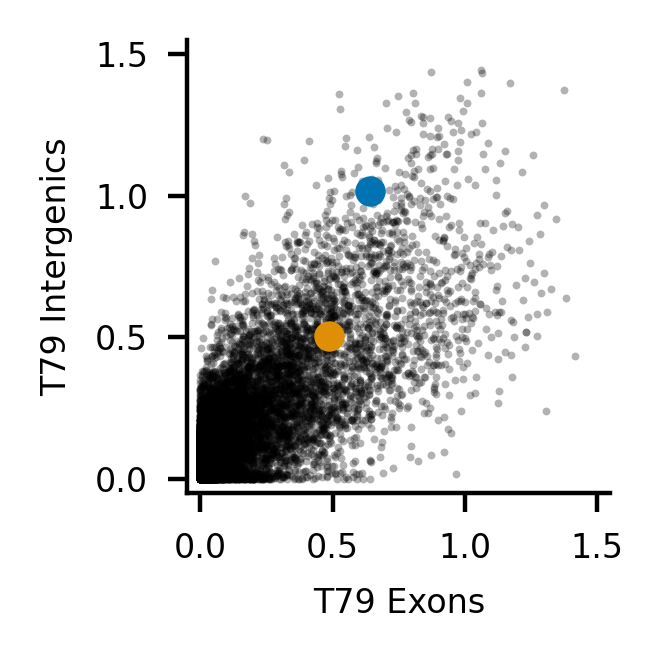

(43, 41, 3)


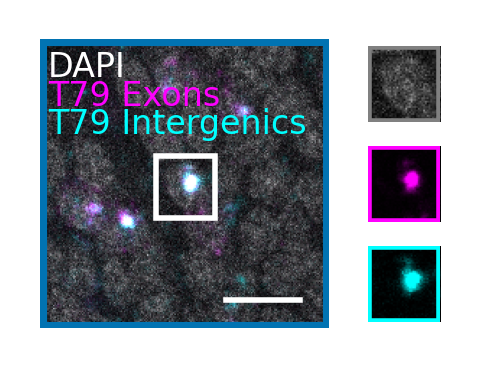

(37, 42, 3)


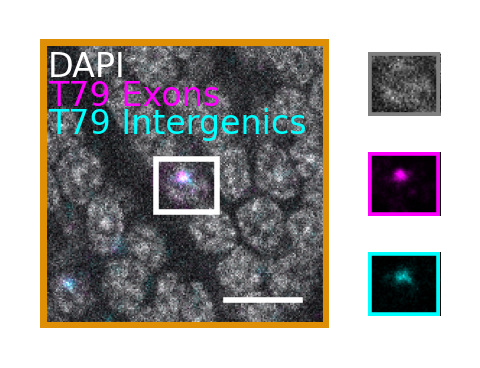

In [166]:
# T79-intergenic-b2-647 T79-exonic-b1-546 
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="T79 Exons", c2_name="T79 Intergenics",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0.6, 1], [0.5, 0.5]],
                dapi_max=150, c1_max=200, c2_max=200)

## Chymotrypsin & U34

In [167]:
input = 'U34'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory


In [168]:
channels = ['AF546', 'AF647']
channel_names = ["U34", "Chymotrypsin"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

In [169]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 202, 3, 2048, 2048)
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_rois.npy


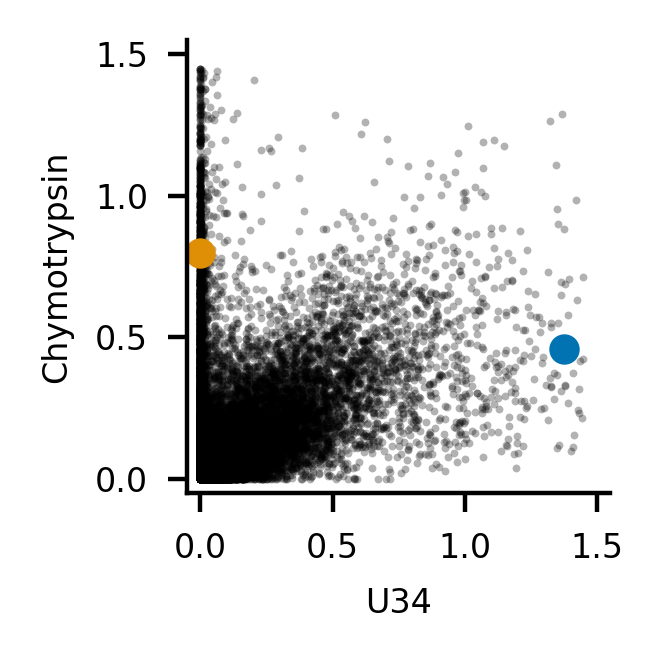

(42, 39, 3)


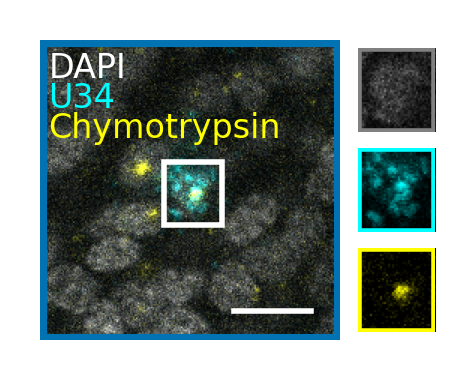

(37, 41, 3)


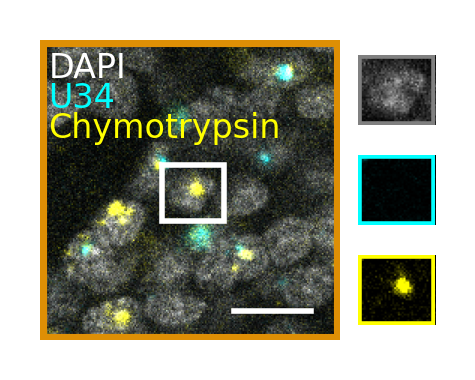

In [170]:
# U34-B3-546 Chymotrypsin-B2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="U34", c2_name="Chymotrypsin",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[1.4, 0.5], [0, 0.8]], 
                dapi_max=200, c1_max=100, c2_max=100)

# Supplementary 1 

## LOC603 & 9E108

In [171]:
input = 'LOC603'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI as input directory


In [172]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [173]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")


Loaded ../../../RNA-FISH-raw-data/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 88, 4, 2048, 2048)
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 3_rois.npy


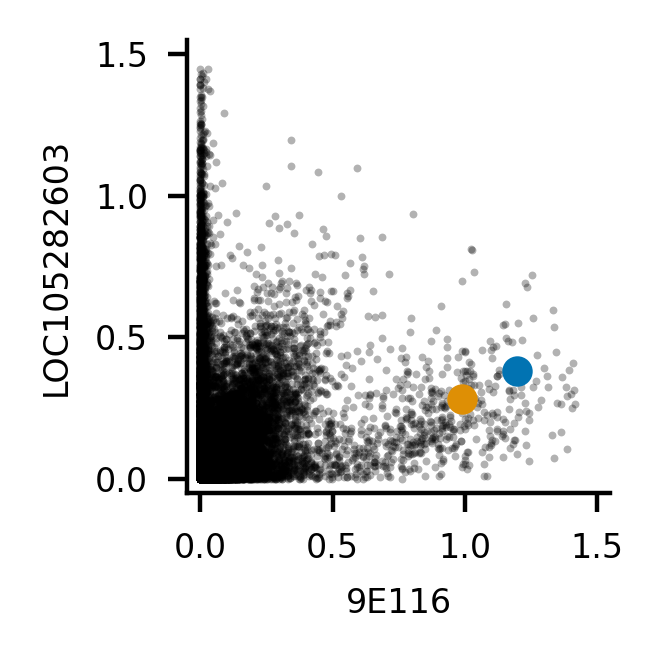

(53, 48, 3)


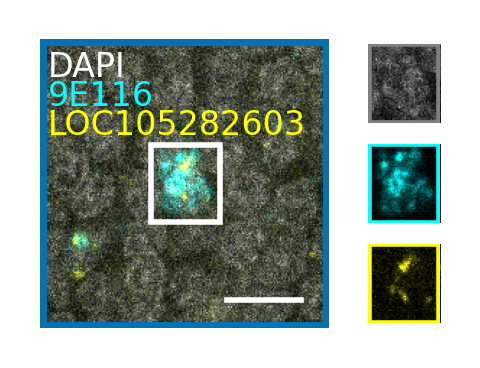

(50, 49, 3)


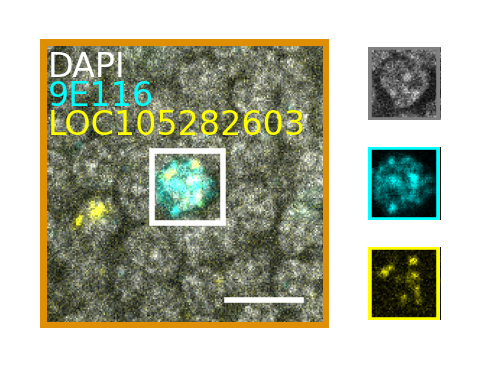

In [174]:
# LOC603-b3-488 9E108-b1-546 9E116-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF647-nuc-norm", c2="AF488-nuc-norm", 
                c1_name="9E116", c2_name="LOC105282603",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[1.2, 0.4], [1, 0.3]], bbox_expansion=8, 
                dapi_max=150, c1_max=200, c2_max=100)

## 9E99 & LOC105286072

In [175]:
input = 'LOC105286072'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI as input directory


In [176]:
channels = ['AF594', 'AF647']
channel_names = ["9E99", "LOC105286072"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

In [177]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../../../RNA-FISH-raw-data/20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI/20250508 9e99 loc072 sample 1.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF647-T1', 'DAPI-T2', 'AF594-T2']}
Image shape: (1, 91, 3, 2048, 2048)
Loaded ../results/20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI/20250508 9e99 loc072 sample 1_rois.npy


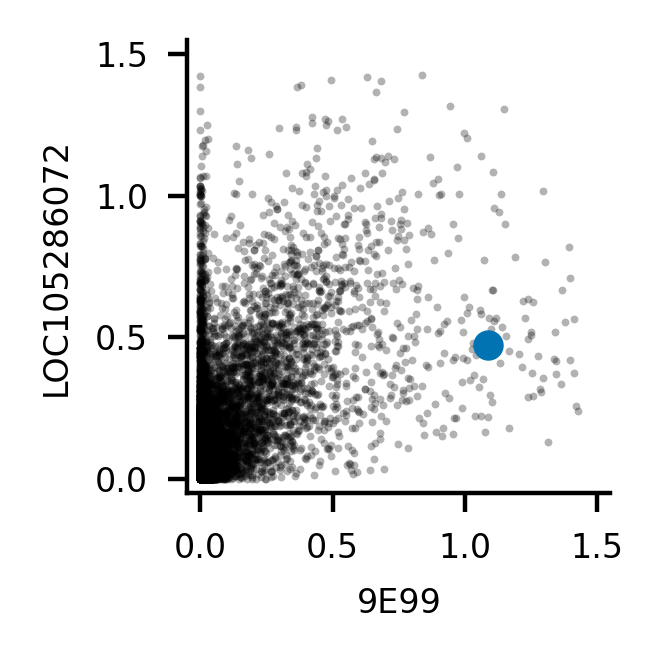

(50, 43, 3)


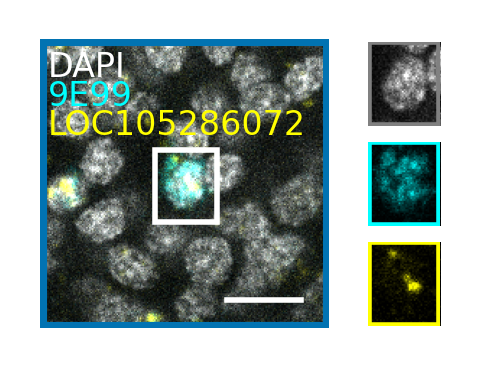

In [178]:
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF594-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="9E99", c2_name="LOC105286072",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[1.1, 0.5]], bbox_expansion=8, 
                dapi_max=255, c1_max=200, c2_max=200)

# FIGURE 2

## 9E213 & 9E214 & Intergenic

In [179]:
input = '20250523 A'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})


figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI as input directory


In [180]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E214", "9E213", "IPR"]
channel_colors = ["yellow", "cyan", "magenta"]
channel_maxs = [255, 255, 255]

In [181]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI/sample 3 stack 2048p.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 96, 4, 2048, 2048)
Loaded ../results/20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI/sample 3 stack 2048p_rois.npy
Loaded ../results/20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI/sample 3 stack 2048p_cell_borders.npy


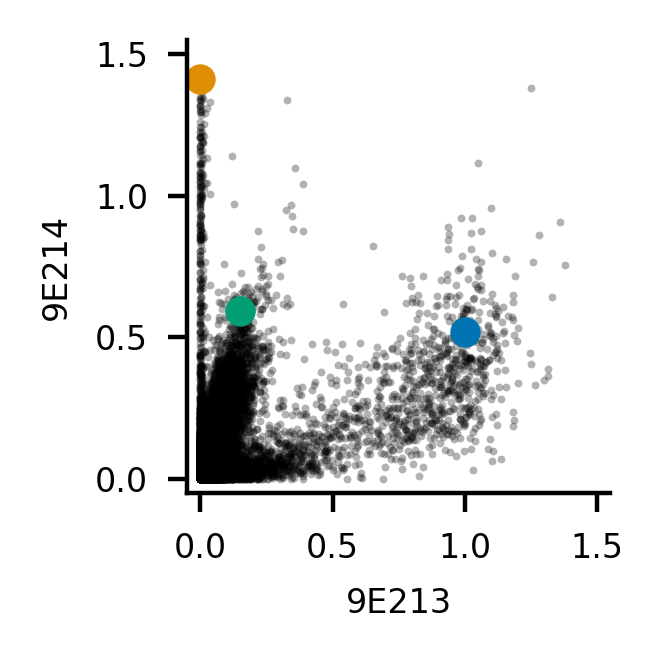

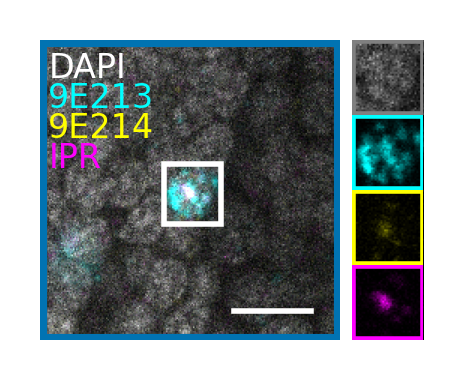

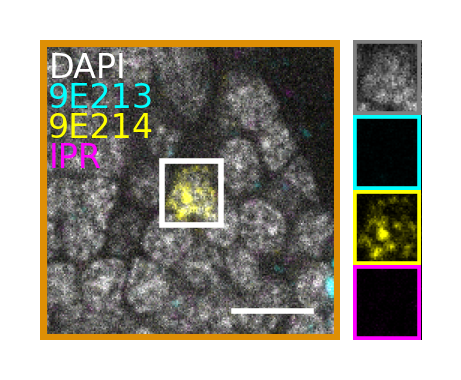

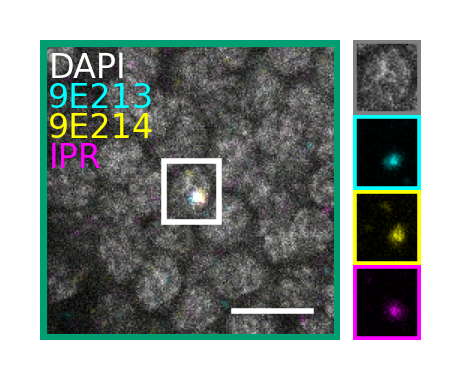

In [182]:
# 9E213-546 9E214-488 Intergenic-647
plot_3_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF488-nuc-norm", c3="AF647-nuc-norm",
                c1_name="9E213", c2_name="9E214", c3_name="IPR",
                c1_color="cyan", c2_color="yellow", c3_color="magenta",
                coordinates=[[1, 0.55], [0, 1.4], [0.15, 0.6]], # 1.1, 0.7 
                dapi_max=200, c1_max=150, c2_max=180, c3_max=150)

## 9E129 & 9E118-exons & 9E118-introns

In [183]:
input = '9E118'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

# How many images? 
print(f"Number of images: {results['image'].nunique()}")

Using 20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI as input directory
Number of images: 5


In [184]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../../../RNA-FISH-raw-data/20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI/20250701 A stack sample 4.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 89, 4, 2048, 2048)
Loaded ../results/20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI/20250701 A stack sample 4_rois.npy


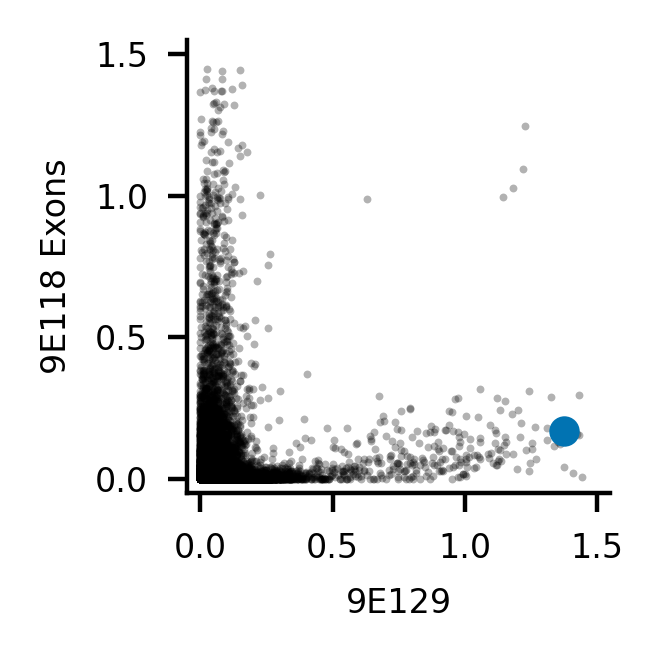

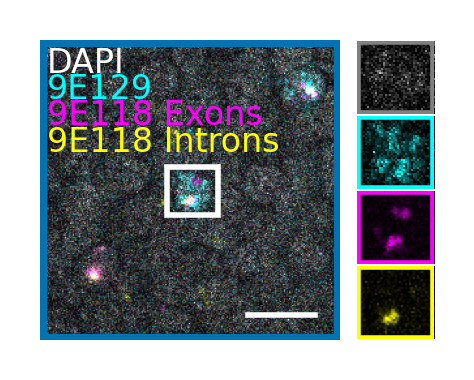

In [185]:
# 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488
plot_3_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF546-nuc-norm", c3="AF647-nuc-norm",
                c1_name="9E129", c2_name="9E118 Exons", c3_name="9E118 Introns",
                c1_color="cyan", c2_color="magenta", c3_color="yellow",
                coordinates=[[1.3, 0.3]], bbox_expansion=5, pixel_bounds=115,
                dapi_max=120, c1_max=100, c2_max=70, c3_max=255)

# Supplementary 3

## LOC104 & 9E116 (Kr-h1)

In [186]:
input = 'LOC104'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI as input directory


In [187]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "Kr-h1", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [188]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI/20250328 4 KLF sample 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 94, 4, 2048, 2048)
Loaded ../results/20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI/20250328 4 KLF sample 3_rois.npy
Loaded ../results/20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI/20250328 4 KLF sample 3_cell_borders.npy


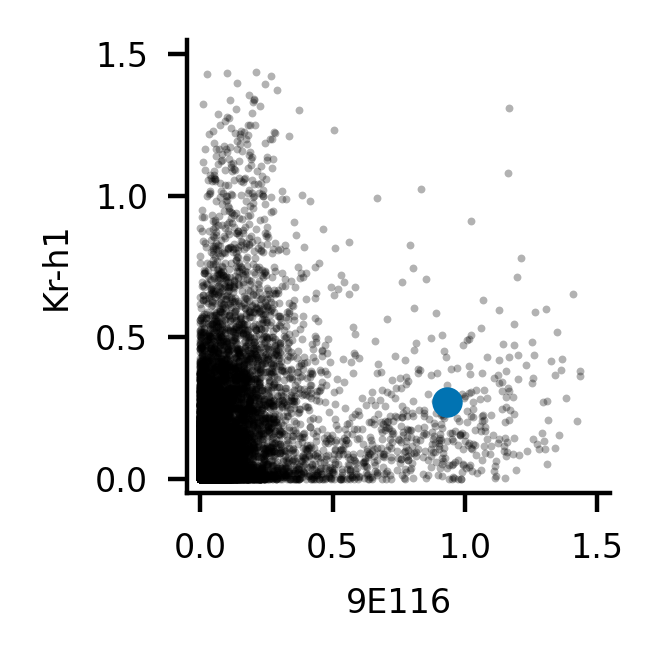

(48, 47, 3)


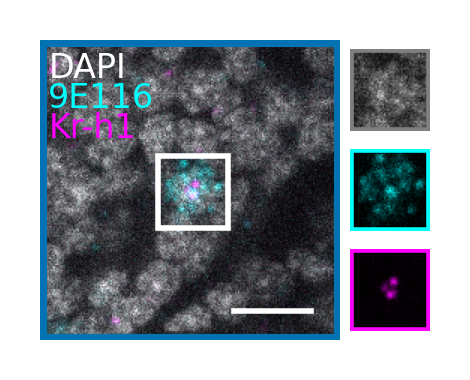

In [189]:
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF647-nuc-norm", c2="AF546-nuc-norm", 
                c1_name="9E116", c2_name="Kr-h1",
                c1_color="cyan", c2_color="magenta",
                coordinates=[[1, 0.3]], bbox_expansion=8, 
                dapi_max=255, c1_max=150, c2_max=150)

# FIGURE 4

## U34, U21, PR

In [190]:
input = 'U21'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI as input directory


In [191]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [192]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI/20250325 4 t19 lncrna sample 4 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 30779.721115112305, 26878.52767944336), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 80, 4, 2048, 2048)
Loaded ../results/20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI/20250325 4 t19 lncrna sample 4 great_rois.npy
Loaded ../results/20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI/20250325 4 t19 lncrna sample 4 great_cell_borders.npy


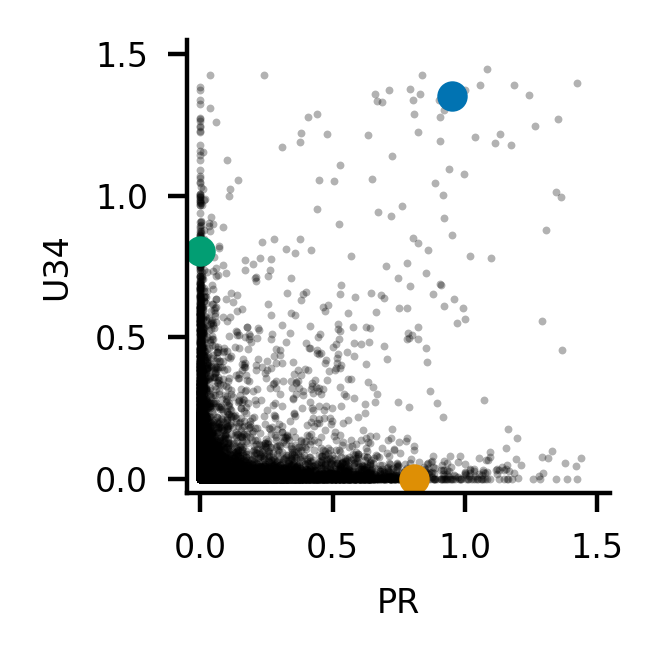

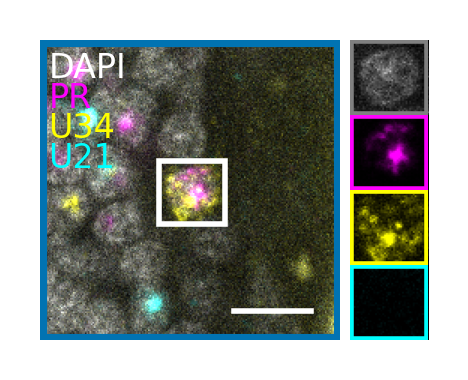

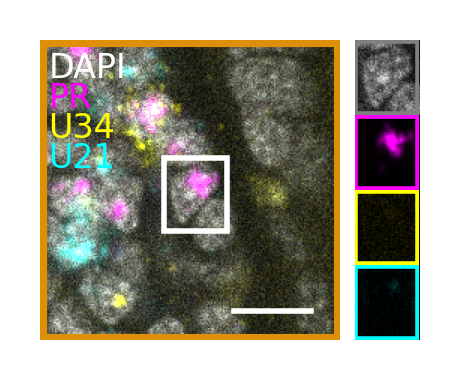

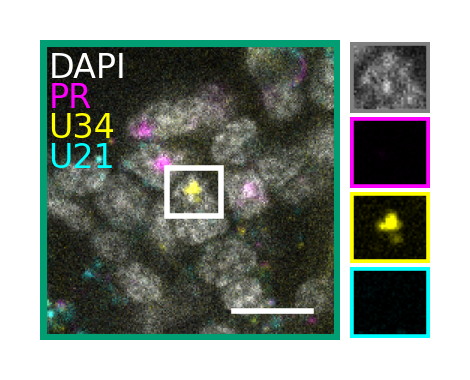

In [193]:
# u34-b3-488 lnc4-b1-546 u21-b5-647
plot_3_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF488-nuc-norm", c3="AF647-nuc-norm",
                c1_name="PR", c2_name="U34", c3_name="U21",
                c1_color="magenta", c2_color="yellow", c3_color="cyan",
                coordinates=[[1, 1.3], [0.8, 0], [0, 0.8]],
                dapi_max=200, c1_max=200, c2_max=150, c3_max=150)

## G1 & lncRNA

In [121]:
input = 'G1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI as input directory


In [122]:
channels = ['AF546', 'AF647']
channel_names = ["G1", "LOC113562161"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [123]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI/20250325 5 G1 lncrna sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI/20250325 5 G1 lncrna sample 2 great_rois.npy
Loaded ../results/20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI/20250325 5 G1 lncrna sample 2 great_cell_borders.npy


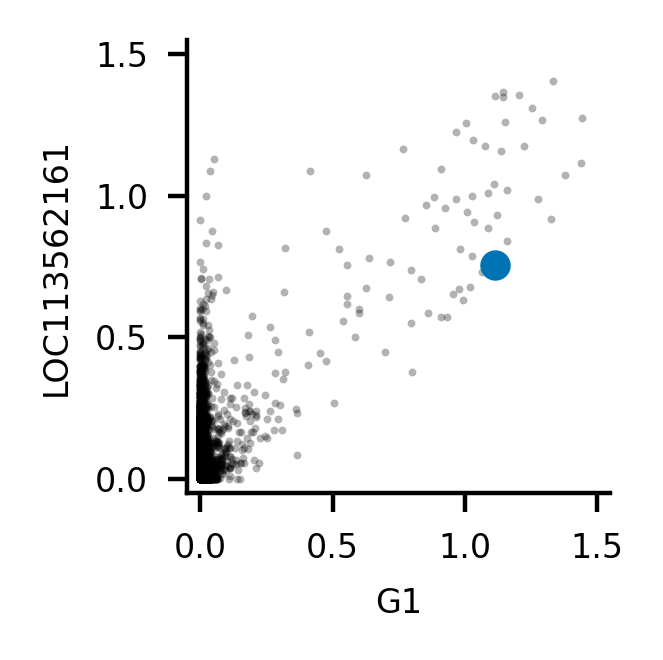

(54, 52, 3)


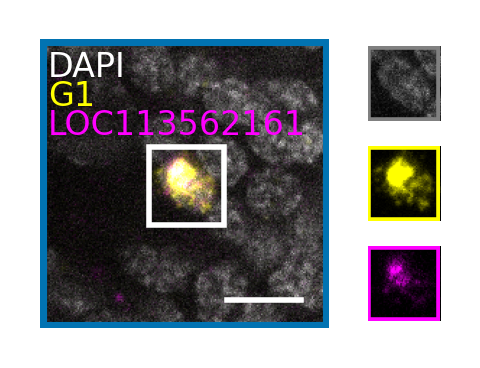

In [124]:
# g1-b1-546 lnc7-b2-647
plot_2_channels(results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="G1", c2_name="LOC113562161",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[1.1, 0.8]], bbox_expansion=7,
                dapi_max=200, c1_max=100, c2_max=100)

## 9E88 & lncRNA

In [125]:
input = '20250523 B'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 B P14 T 9E88-546 Lnc-647 DAPI as input directory


In [126]:
channels = ['AF546', 'AF647']
channel_names = ["9E88", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [127]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250523 B P14 T 9E88-546 Lnc-647 DAPI/20250523 B sample 2 stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 85, 3, 2048, 2048)
Loaded ../results/20250523 B P14 T 9E88-546 Lnc-647 DAPI/20250523 B sample 2 stack_rois.npy
Loaded ../results/20250523 B P14 T 9E88-546 Lnc-647 DAPI/20250523 B sample 2 stack_cell_borders.npy


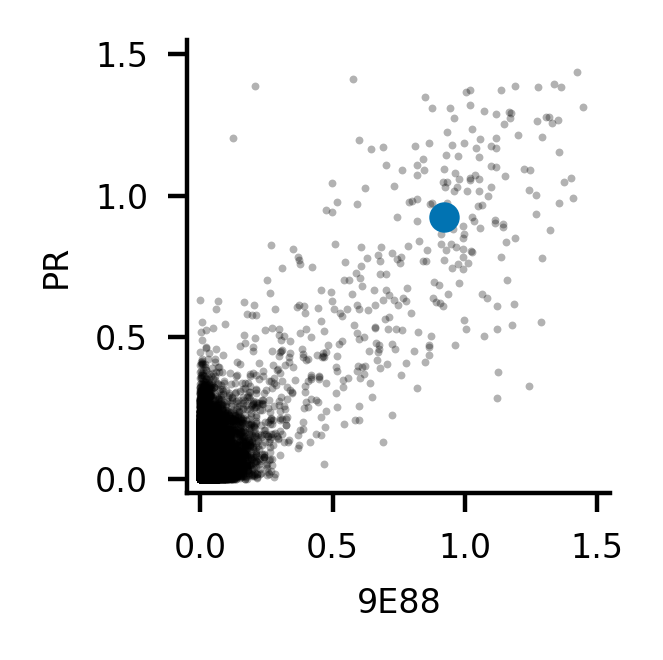

(43, 54, 3)


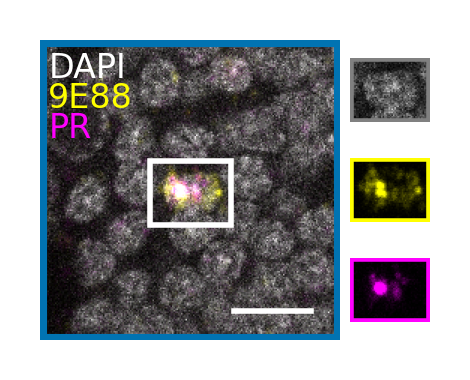

In [128]:
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="9E88", c2_name="PR",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[0.9, 0.9]], bbox_expansion=8, 
                dapi_max=255, c1_max=200, c2_max=200)

# Supplementary 4

## Q1, R2, PR

In [194]:
input = 'Q1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory


In [195]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["R2/3", "Q1", "PR"]
channel_colors = ["cyan", "yellow", "magenta"]
channel_maxs = [255, 255, 255]

In [196]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_rois.npy
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_cell_borders.npy


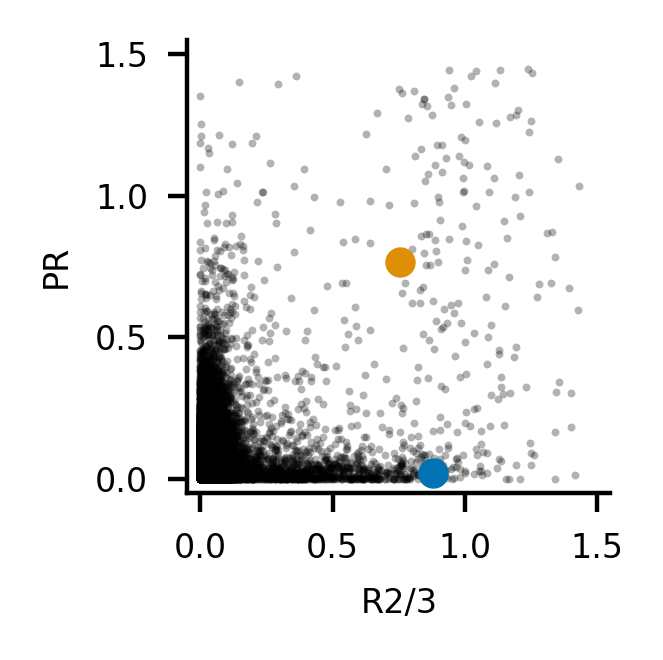

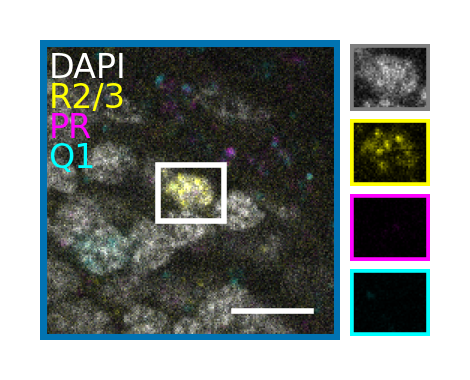

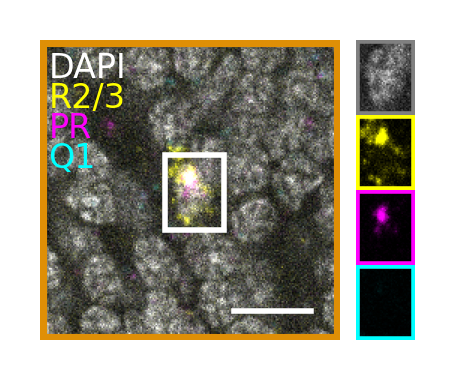

In [197]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647
plot_3_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF647-nuc-norm", c3="AF546-nuc-norm",
                c1_name="R2/3", c2_name="PR", c3_name="Q1",
                c1_color="yellow", c2_color="magenta", c3_color="cyan", bbox_expansion=6, 
                coordinates=[[0.9, 0], [0.8, 0.8]], 
                dapi_max=200, c1_max=150, c2_max=200, c3_max=200)

## L16 & PR

In [137]:
input = 'L16'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI as input directory


In [138]:
channels = ['AF594', 'AF647']
channel_names = ["L16", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [139]:
file_number = 2
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF488-T1', 'AF647-T1', 'DAPI-T2', 'AF594-T2']}
Image shape: (1, 81, 4, 2048, 2048)
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_rois.npy
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_cell_borders.npy


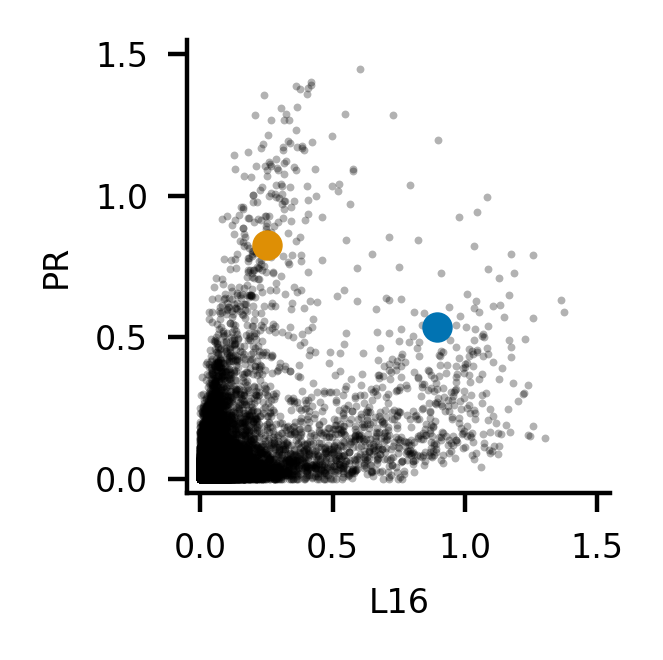

(48, 42, 3)


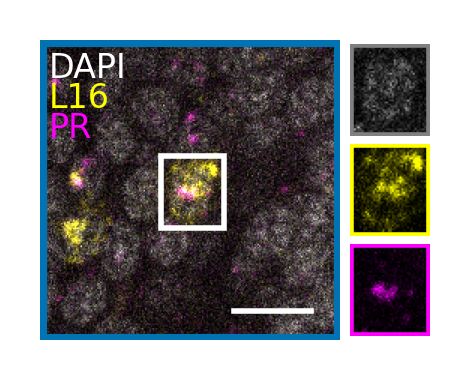

(46, 47, 3)


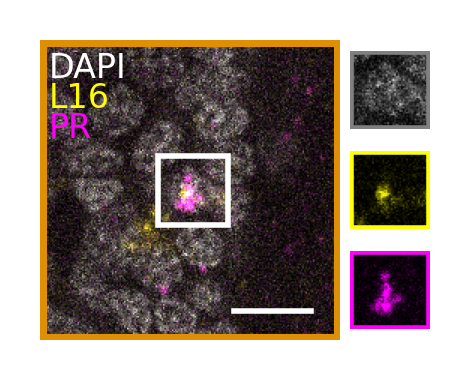

In [140]:
# Lnc3-b3-488 L16-b2-594 Lnc2-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF594-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="L16", c2_name="PR",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[0.9, 0.5], [0.25, 0.85]], bbox_expansion=7,
                dapi_max=100, c1_max=150, c2_max=100)

## U54 & PR

In [141]:
input = '20250523 C'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250523 C P14 T U54-647 Lnc4-546 DAPI as input directory


In [142]:
channels = ['AF647', 'AF546']
channel_names = ["U54", "PR"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [143]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250523 C P14 T U54-647 Lnc4-546 DAPI/20250523 C sample 4 stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 94, 3, 2048, 2048)
Loaded ../results/20250523 C P14 T U54-647 Lnc4-546 DAPI/20250523 C sample 4 stack_rois.npy
Loaded ../results/20250523 C P14 T U54-647 Lnc4-546 DAPI/20250523 C sample 4 stack_cell_borders.npy


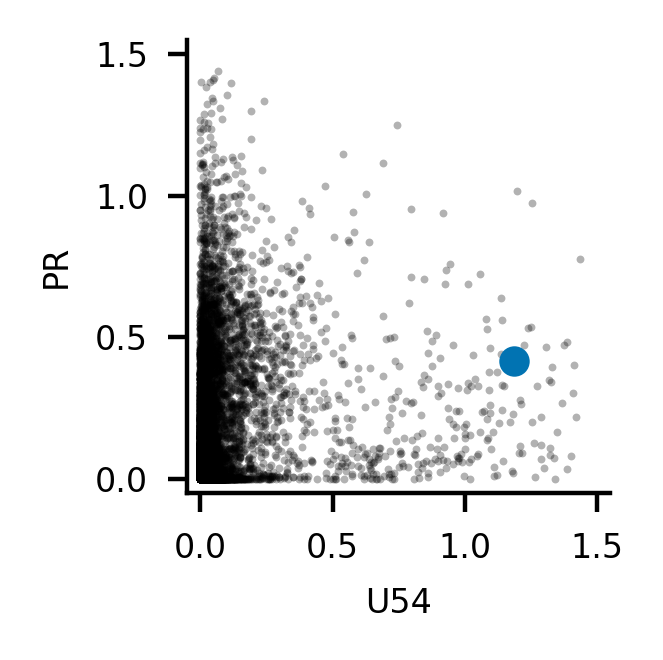

(44, 50, 3)


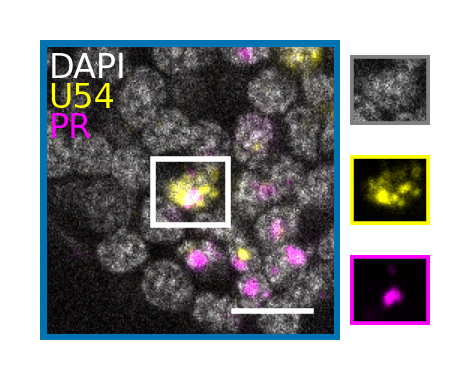

In [144]:
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF647-nuc-norm", c2="AF546-nuc-norm", 
                c1_name="U54", c2_name="PR",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[1.2, 0.4]], bbox_expansion=8, 
                dapi_max=255, c1_max=200, c2_max=200)

# FIGURE 7

## 9E89 & 9E99

In [145]:
input = '9E89'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI as input directory


In [146]:
channels = ['AF546', 'AF647']
channel_names = ["9E89", "9E99"]
channel_colors = ["yellow", "magenta"]
channel_maxs = [255, 255]

In [147]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI/20250508 9e89 9e99 sample 1.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 85, 3, 2048, 2048)
Loaded ../results/20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI/20250508 9e89 9e99 sample 1_rois.npy
Loaded ../results/20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI/20250508 9e89 9e99 sample 1_cell_borders.npy


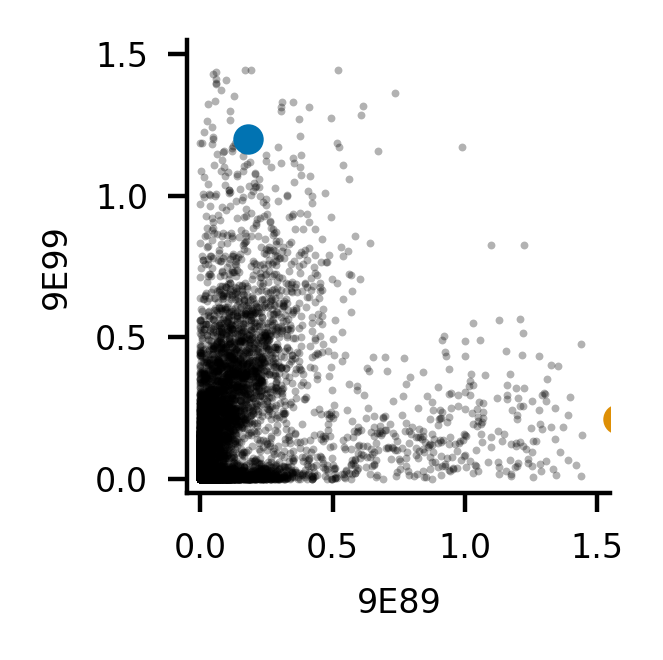

(50, 50, 3)


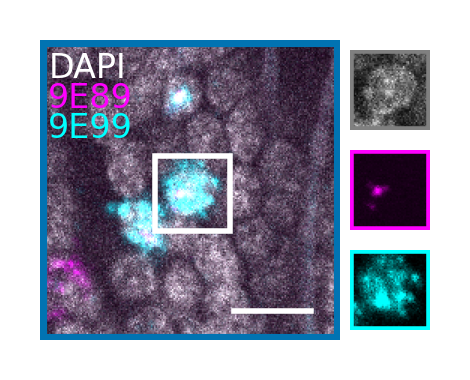

(51, 47, 3)


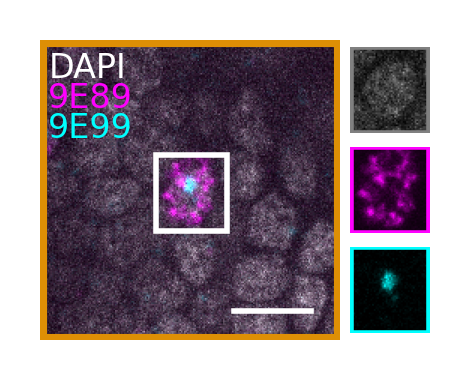

In [153]:
# U34-B3-546 Chymotrypsin-B2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="9E89", c2_name="9E99",
                c1_color="magenta", c2_color="cyan", bbox_expansion=8,
                coordinates=[[0.2, 1.4], [1.4, 0.5]], # [0.7, 0.3]
                dapi_max=120, c1_max=150, c2_max=200)

# Supplementary 7

## 9E196, 9E197, 9E198

In [154]:
input = '9E198'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')

# Load the results 
results_dir = f'../results/{input}'
results = pd.read_csv(os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv'))
results_melted = pd.read_csv(os.path.join(results_dir, 'all_results_melted.csv'), dtype={'channel_name': str})

figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)

Using 20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI as input directory


In [155]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E198", "9E197", "9E196"]
channel_colors = ["magenta", "cyan", "yellow"]
channel_maxs = [255, 255, 255]

In [156]:
file_number = 2
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../../../RNA-FISH-raw-data/20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI/20250325 5 t35 sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 102, 4, 2048, 2048)
Loaded ../results/20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI/20250325 5 t35 sample 2 great_rois.npy
Loaded ../results/20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI/20250325 5 t35 sample 2 great_cell_borders.npy


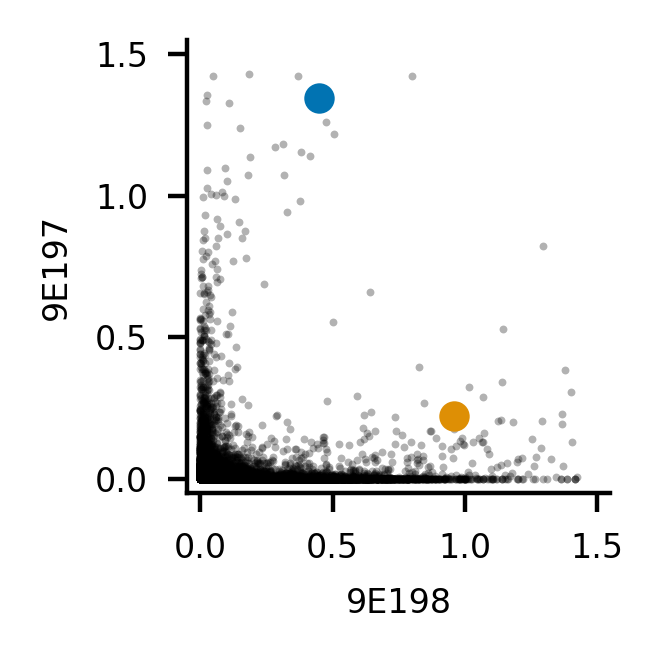

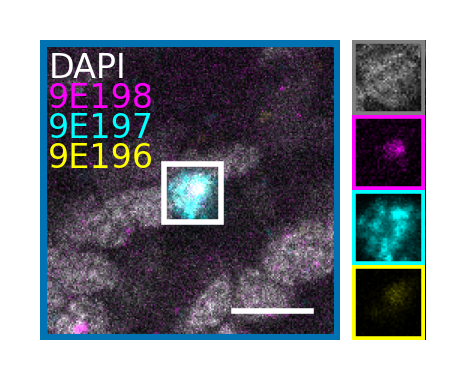

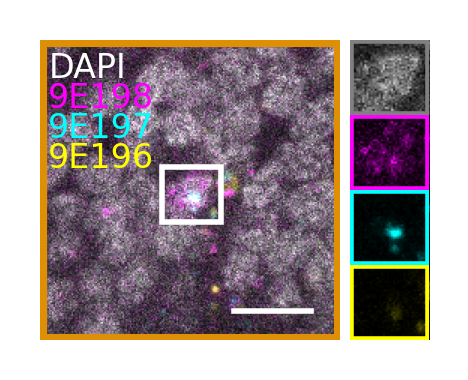

In [160]:
# 9e198-b3-488 9e197-b1-546 9e196-b2-647
plot_3_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF546-nuc-norm", c3="AF647-nuc-norm",
                c1_name="9E198", c2_name="9E197", c3_name="9E196",
                c1_color="magenta", c2_color="cyan", c3_color="yellow",
                coordinates=[[0.4, 1.3], [1.1, 0.3]],
                dapi_max=150, c1_max=70, c2_max=90, c3_max=200)